## Advanced aperture photometry
This notebook provides code to perform aperture photometry on a sequence of images where the target star is not shifting by more than ~50 or 100 pixels. It allows you to repeat measurements without going in by hand and redoing everything.

This notebook is basically the aperture photometry notebook (in this same directory), except for this notebook allows you to select (via coordinates) exactly which stars you are going to use as comparison stars.

Lab 3 detailed how to do simple aperture photometry. I highly recommend going through Lab 3 before this so that you understand what is going on here.

We are going to use Group 3's observations of SW Lac for this exercise.

### Identifying the star of interest.
First we need to identify which star is SW Lac. Begin by opening up the source in simbad. Look at the "aladin lite" view of the source. Try to identify features like triangles and visual binaries (stars that appear to be close together) and try and pinpoint which star is SW Lac. *Usually*, the star of interest will be near the center of the image.

![](ap_photometry_resources/SW_Lac_simbad.png)

<IPython.core.display.Javascript object>


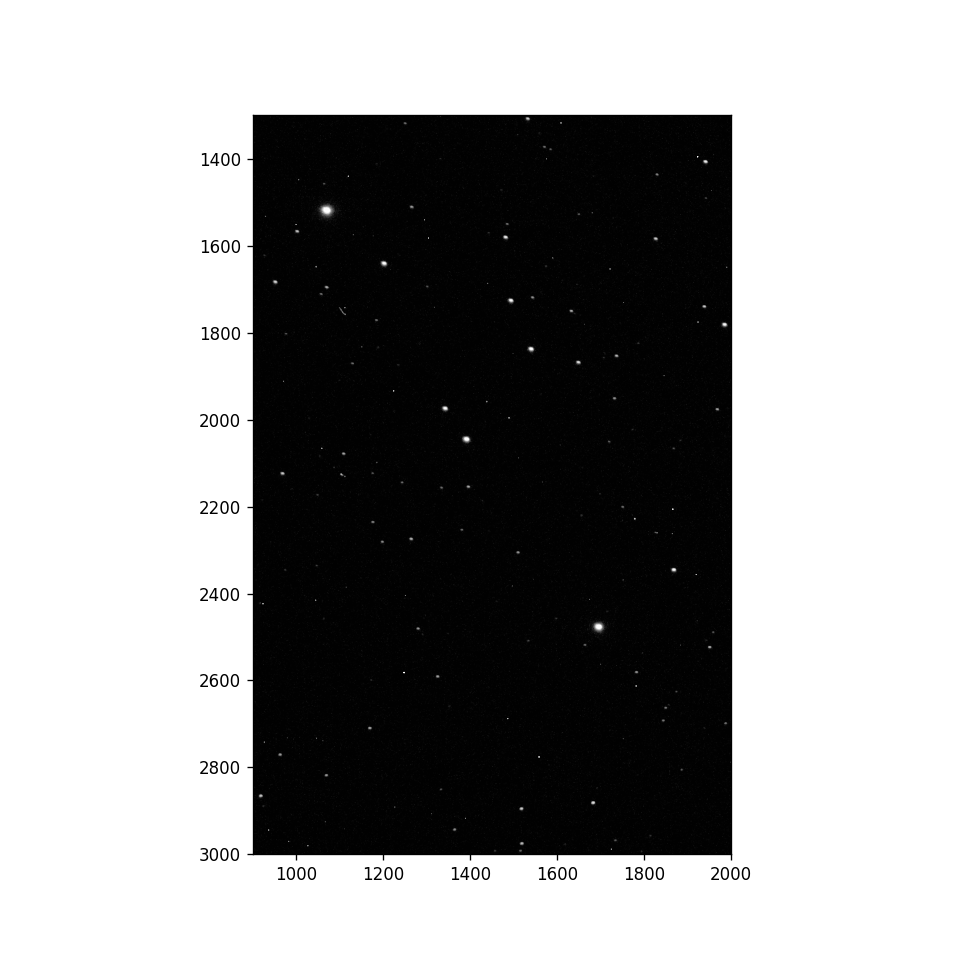

(3000.0, 1300.0)

In [1]:
# Now lets pull up the image in python:
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
import numpy as np

%matplotlib notebook
%matplotlib notebook


hdulist = fits.open('ap_photometry_resources/elp0m411-kb92-20210708-0028-e91.fits.fz') # im 1
#hdulist = fits.open('ap_photometry_resources/elp0m411-kb92-20210708-0038-e91.fits.fz') # im 2
im = hdulist['SCI'].data

plt.figure(figsize=(8,8))
display_image = np.copy(im)
min_clip = 30
display_image[display_image<min_clip] = min_clip + 1 # will remove the 'static' of white dots
plt.imshow(np.rot90(display_image, k=-1), norm=LogNorm(vmin=min_clip, vmax=5000), cmap='Greys_r')
plt.xlim((900, 2000)) # zoom in.
plt.ylim((3000, 1300)) # zoom in.

Its plainly clear that the bright star in the top left of the image above is SW Lac. Now we are going to use a python package called photutils to find all the stars in our image.

In [2]:
from photutils import DAOStarFinder


uncertainty_im = hdulist['ERR'].data  # this is the uncertainty image.

minimum_pixel_size_of_stars = 10  # only finds stars with a pixel width exceeding 10 pixels. SW Lac has a width of like 40 pixels in the image.
minimum_signal_to_noise = 10  # only finds stars with a minimum signal to noise (per pixel) of 10.

signal_to_noise_image = im/uncertainty_im

daofind = DAOStarFinder(fwhm=minimum_pixel_size_of_stars, threshold=minimum_signal_to_noise, exclude_border=True)
all_sources = daofind(signal_to_noise_image)  # it is important that we feed the image/uncertainty_image here so that our signal-to-noise cutoff works.

Now we can go ahead and redisplay the image with the stars that daofind found, marked with red crosses.


<IPython.core.display.Javascript object>


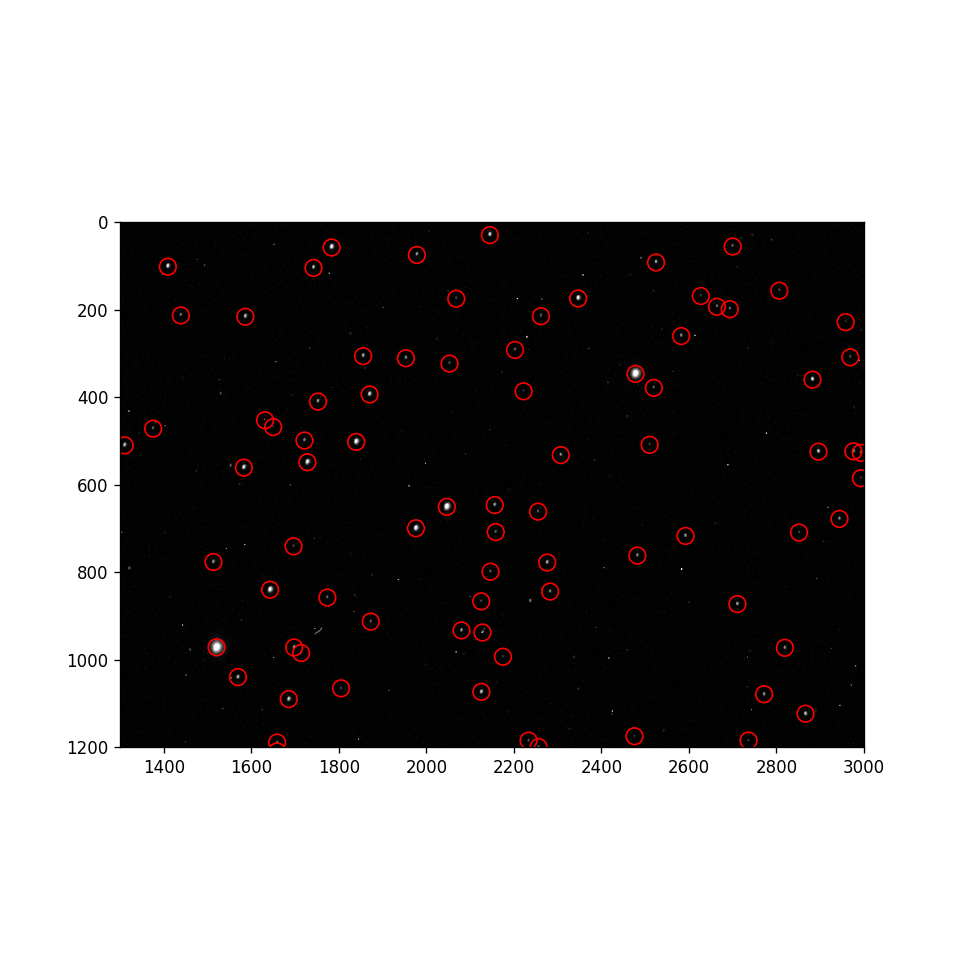

(1300.0, 3000.0)

In [3]:
plt.figure(figsize=(8,8))
display_image = np.copy(im)
min_clip = 30
display_image[display_image<min_clip] = min_clip + 1 # will remove the 'static' of white dots
plt.imshow(display_image, norm=LogNorm(vmin=min_clip, vmax=5000), cmap='Greys_r')
plt.scatter(all_sources['xcentroid'], all_sources['ycentroid'], marker='o', facecolor='none', s=100, edgecolor='r')
plt.ylim((1200, 0)) # zoom in.
plt.xlim((1300, 3000)) # zoom in.

Note that we have left the image above non-rotated. SW Lac is now the bright star in the bottom left.

Now we want to mock up some code to find SW Lac in any image that we feed, where SW Lac is at least in the same region of the sky. 
In pseudo code we are going to:
1. Select all stars in the y,x region you want
2. Perform aperture photometry on those stars.
3. SW Lac is going to always be the brightest star in that region, so take that table of flux values and get me the row with the largest flux. That must be SW Lac.
Done!

There are going to be functions here that you have never seen before. Like np.logical_and. Please look up the documentation for them! E.g., https://numpy.org/doc/stable/reference/generated/numpy.logical_and.html

In [4]:
x_limits = (1300, 3000)
y_limits = (1200, 0)

sources_that_have_correct_x_coordinate = np.logical_and(all_sources['xcentroid'] > min(x_limits), all_sources['xcentroid'] < max(x_limits))
sources_that_have_correct_y_coordinate = np.logical_and(all_sources['ycentroid'] > min(y_limits), all_sources['ycentroid'] < max(y_limits))

sources_that_are_in_our_box = np.logical_and(sources_that_have_correct_x_coordinate, sources_that_have_correct_y_coordinate)

sources = all_sources[sources_that_are_in_our_box]

In [5]:
# these are all the sources found. THere should be an equal number of red circles in the above image as there
# are rows in this table
print(sources)

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 2145.1841755378814 ... 10.381629232611344   -2.540663786288138
  2  2699.926288912065 ... 2.1858950598636273  -0.8490732714174254
  3 1783.6293791622195 ...  16.96965943332411   -3.074182816207828
  4 1978.3552566246778 ... 4.4848942470810025  -1.6293805173072187
  7 2524.8013231589807 ... 5.4034604298053415  -1.8316799385611662
  8 1409.3327564348674 ... 12.864593219500101   -2.773490145755834
  9 1742.1539149932617 ...  6.799769166531411   -2.081235424632051
 10 2806.4992580677476 ... 1.4847981512836812  -0.4291685453419447
 11 2627.1241911703837 ...  1.279568007515159 -0.26765843267732464
 13  2346.966964924942 ... 17.297056386089267  -3.0949305029013523
...                ... ...                ...                  ...
 98 1569.5507527414497 ...  6.598322058829357   -2.048583773233585
101  1805.109704910611 ... 1.4476901614358753  -0.401689057316

OK so everything looks good! Ignore the flux and mag columns. We are going to compute those ourselves.

In [6]:
from photutils import CircularAperture
# in the lab, you used a square aperture. Circular is slightly better.
# SW Lac is bright, so the light is spread out wide, so we are going to use a circular aperture of 30. I arrived
# at the value of 30 by just zooming into SW Lac in the image above. We want to catch ALL of the light coming from
# the star.

positions = [(s['xcentroid'], s['ycentroid']) for s in sources] # make a list of (x, y) tuple positions
# yes this time you should really use x,y  , not y,x!!! Amazing I know. Something intuitive for once!
print(len(positions), 'sources')

80 sources


In [7]:
from photutils.aperture import aperture_photometry

aperture = CircularAperture(positions, r=30.)
phot_table = aperture_photometry(im, aperture, error=uncertainty_im)
phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id      xcenter            ycenter       aperture_sum  aperture_sum_err
           pix                pix                                       
--- ------------------ ------------------ ------------ -----------------
  1 2145.1841755378814  29.48028969886468    61940.941 849.4165046068547
  2  2699.926288912065  55.59362848663204    31028.415 834.1536143515568
  3 1783.6293791622195  57.80794919027851    122834.04 895.9553421903063
  4 1978.3552566246778  74.71309805947543    37129.728 846.0058174845515
  5 2524.8013231589807   92.0569599927713    38208.823 846.3134000626171
  6 1409.3327564348674 101.65758289375079    110382.16  937.782390578005
  7 1742.1539149932617 104.46356649621693     45298.78  862.551508928001
  8 2806.4992580677476 156.53481004577543     29209.25  838.073448020482
  9 2627.1241911703837 168.62109706891053    28157.693  850.907792006595
 10  2346.966964924942 174.35753162616135    116856.15 891.6681988119122
...                ...                ...          

In [8]:
phot_table.sort('aperture_sum', reverse=True)
print(phot_table)
print('note that the square of the aperture_sum_err column is within about a factor of two of aperture_sum itself.')

 id      xcenter            ycenter       aperture_sum  aperture_sum_err 
           pix                pix                                        
--- ------------------ ------------------ ------------ ------------------
 65 1520.6772492632265  971.2919896940806      3037146 2221.3471507819168
 24 2477.8614770607537 346.63974531719396    2169726.5 1913.0095798991483
 45 2046.8129924311534  650.3081341978472    488694.96 1084.1276483836336
 57 1642.9572075010644  839.7079392957996    191276.19  923.9793818310136
 34  1839.723099129503  502.0475913206177    184759.42   920.881276130829
 48 1976.1649930861545  699.4035475757099    153783.31  894.9671623657355
 41 1728.2359137680082  548.4710222335017    130878.25  887.0024807577161
  3 1783.6293791622195  57.80794919027851    122834.04  895.9553421903063
 10  2346.966964924942 174.35753162616135    116856.15  891.6681988119122
  6 1409.3327564348674 101.65758289375079    110382.16   937.782390578005
...                ...                

#### Look at the top most column. The aperture_sum is 3 million! Compared to the next brightest star has 2 million (this is the comparison star). So the 3 million star must be the brightest. The brightest star in the image is SW Lac, and so we have found a reliable way to find SW Lac. Just take the star (in our little sub region) that is the brightest.


Ok, now we could compute the flux of our star relative to the other brightest stars that we saw in the image. This will give us a roughly constant set point. Normally, you would want to do this "comparison" with a set of standard stars in the field (instead of just random nearby stars that I see).

Anchoring the flux to a set of "comparison stars" (the same within each image!) will cause our fluxes/exposure_time to (hopefully) be calibrated. Meaning any variation that we see is just due to variations in SW Lac.

For SW Lac, there is a nearby star, in the region we selected, that is a good star to use as a comparison star. We will compute the brightness of SW Lac relative to this star (comparing the brightness, hence the name "comparison star"). This star is BD+37 4715 and is the second brightest star in that region. It is near x,y coordinate 2480, 340. 

In [9]:
from astropy.table import vstack

def find_brightest_near(phot_table, x, y, r):
    sources_that_have_correct_x_coordinate = np.isclose(phot_table['xcenter'].value, x, atol=r)
    sources_that_have_correct_y_coordinate = np.isclose(phot_table['ycenter'].value, y, atol=r)

    sources_that_are_nearby_xy = np.logical_and(sources_that_have_correct_x_coordinate, sources_that_have_correct_y_coordinate)
    phot_table_nearby = phot_table[sources_that_are_nearby_xy]
    phot_table_nearby.sort('aperture_sum', reverse=True)
    if len(phot_table_nearby) == 0:
        return None
    return phot_table_nearby[0]

comparison_stars = {'x': [2480], 'y': [340], 'r': [300]}
# I am going to find the brightest star near 2480, 340 within a radius of 300. This will be the desired comparison star.

number_of_comparison_stars = len(comparison_stars['x'])
comparison_star_phot_table = []
for i in range(number_of_comparison_stars):
    x, y, r = comparison_stars['x'][i], comparison_stars['y'][i], comparison_stars['r'][i]
    comparison_star_information = find_brightest_near(phot_table, x, y, r)
    comparison_star_phot_table.append(comparison_star_information)
    
comparison_star_phot_table = vstack(comparison_star_phot_table)

# lets be safe and grab the flux of the brightest star near sw lac. Instead of just doing the zeroth row of the image.
sw_lac_coords = {'x': 1500, 'y':   970, 'r': 300} # sw lac is going to be within 300 pixels of 1500, 970
sw_lac_information = find_brightest_near(phot_table, sw_lac_coords['x'], sw_lac_coords['y'], sw_lac_coords['r'])

sw_lac_flux = sw_lac_information['aperture_sum']
sw_lac_flux_error = sw_lac_information['aperture_sum_err']

comparison_star_flux = np.average(comparison_star_phot_table['aperture_sum'])
comparison_star_flux_error = np.sqrt(np.sum(comparison_star_phot_table['aperture_sum_err']**2)/number_of_comparison_stars**2)

Now, as a final step, lets convert to magnitudes. For this, remember we just take $-2.5\cdot \log_{10}(\frac{\rm flux- flux\_sky}{\rm exposure time})$

flux_sky is so small that we will ignore it for now. Although technically this will improve your result slightly.



In [10]:
exposure_time = hdulist['SCI'].header['EXPTIME'] # we will need this later

sw_lac_magnitude = -2.5*np.log10(sw_lac_flux/exposure_time)
comparison_star_magnitude = -2.5*np.log10(comparison_star_flux/exposure_time)
print(sw_lac_magnitude)
print('the relative mag, i.e. sw lac magnitude minus our comparison star is:')
print(sw_lac_magnitude - comparison_star_magnitude)

-11.203095878427263
the relative mag, i.e. sw lac magnitude minus our comparison star is:
-0.36515167887510636


Now for the error in the magnitude, you will remember this from Lab 3 :)

In [11]:
def inst_mag(flux, flux_error, exposure_time):
    ft = flux/exposure_time
    magnitude = -2.5*np.log10(flux/exposure_time)
    var_ft = flux_error**2/exposure_time**2
    var_inst_mag = var_ft * (2.5/ft/np.log(10))**2
    return magnitude, np.sqrt(var_inst_mag)

sw_lac_magnitude, sw_lac_magnitude_error = inst_mag(sw_lac_flux, sw_lac_flux_error, exposure_time)
comparison_star_magnitude, comparison_star_magnitude_error = inst_mag(comparison_star_flux, comparison_star_flux_error,
                                                                      exposure_time)

rel_mag = sw_lac_magnitude - comparison_star_magnitude
rel_mag_error = np.sqrt(sw_lac_magnitude_error**2 + comparison_star_magnitude_error**2)

print(f'The magnitude of SW Lac relative to the average of the comparison stars is {round(rel_mag, 3)} +- {round(rel_mag_error, 4)}')

The magnitude of SW Lac relative to the average of the comparison stars is -0.365 +- 0.0012


### Last part: Putting it all together in functions, then running it on multiple images.

I am going to copy and paste all the above code into functions, then re-run the analysis using those functions, on that first image. I want to verify that I get the same answer. This is testing my code to make sure that I have not made any errors.

Then I am going to run my aperture photometry code on two of the images in the sequence.

In [12]:
from astropy.time import Time
from astropy.table import Table
from glob import glob

def load_image(filepath):
    hdulist = fits.open(filepath)
    mid_image_time = Time(hdulist['sci'].header['date-obs'])
    return hdulist['SCI'].data.astype(float), hdulist['ERR'].data.astype(float), hdulist['SCI'].header['EXPTIME'], mid_image_time

def find_stars(im, uncertainty_im, minimum_pixel_size_of_stars=10, minimum_signal_to_noise=10):
    signal_to_noise_image = im/uncertainty_im

    daofind = DAOStarFinder(fwhm=minimum_pixel_size_of_stars, threshold=minimum_signal_to_noise, exclude_border=True)
    all_sources = daofind(signal_to_noise_image)  # it is important that we feed the image/uncertainty_image here so that our signal-to-noise cutoff works.
    return all_sources

def restrict_sources_to_within_box(all_sources, x_limits=(0, 3000), y_limits=(0, 3000)):
    sources_that_have_correct_x_coordinate = np.logical_and(all_sources['xcentroid'] > min(x_limits), all_sources['xcentroid'] < max(x_limits))
    sources_that_have_correct_y_coordinate = np.logical_and(all_sources['ycentroid'] > min(y_limits), all_sources['ycentroid'] < max(y_limits))

    sources_that_are_in_our_box = np.logical_and(sources_that_have_correct_x_coordinate, sources_that_have_correct_y_coordinate)

    sources = all_sources[sources_that_are_in_our_box]
    return sources

def ap_photometry(sources, im, uncertainty_im, aperture_pixel_radius=30.0):
    positions = [(s['xcentroid'], s['ycentroid']) for s in sources]
    aperture = CircularAperture(positions, r=aperture_pixel_radius)
    phot_table = aperture_photometry(im, aperture, error=uncertainty_im)
    phot_table.sort('aperture_sum', reverse=True)
    return phot_table


def get_relative_magnitude(phot_table, star_coords, comparison_star_coords):
    number_of_comparison_stars = len(comparison_star_coords['x'])
    comparison_star_phot_table = []
    for i in range(number_of_comparison_stars):
        x, y, r = comparison_star_coords['x'][i], comparison_star_coords['y'][i], comparison_star_coords['r'][i]
        comparison_star_information = find_brightest_near(phot_table, x, y, r)
        comparison_star_phot_table.append(comparison_star_information)

    if None in comparison_star_phot_table:
        print('ERROR! at least one of the comparison stars was not found in the image. Check that you are not restricting to a sub region of the image that does not contain the stars.')
        return np.nan, np.nan # short circuit 
    comparison_star_phot_table = vstack(comparison_star_phot_table)

    # lets be safe and grab the flux of the brightest star near sw lac. Instead of just doing the zeroth row of the image.
    star_information = find_brightest_near(phot_table, star_coords['x'], star_coords['y'], star_coords['r'])

    star_flux = star_information['aperture_sum']
    star_flux_error = star_information['aperture_sum_err']

    comparison_star_flux = np.average(comparison_star_phot_table['aperture_sum'])
    comparison_star_flux_error = np.sqrt(np.sum(comparison_star_phot_table['aperture_sum_err']**2)/number_of_comparison_stars**2)

    star_magnitude, star_magnitude_error = inst_mag(star_flux, star_flux_error, exposure_time)
    comparison_star_magnitude, comparison_star_magnitude_error = inst_mag(comparison_star_flux, comparison_star_flux_error,
                                                                          exposure_time)

    rel_mag = star_magnitude - comparison_star_magnitude
    rel_mag_error = np.sqrt(star_magnitude_error**2 + comparison_star_magnitude_error**2)
    
    # relative magnitude and relative_magnitude error
    return rel_mag, rel_mag_error




def inst_mag(flux, flux_error, exposure_time):
    ft = flux/exposure_time
    magnitude = -2.5*np.log10(flux/exposure_time)
    var_ft = flux_error**2/exposure_time**2
    var_inst_mag = var_ft * (2.5/ft/np.log(10))**2
    return magnitude, np.sqrt(var_inst_mag)

# Putting all the above functions together:
def process_image(filepath_to_e91_file, star_coords, comparison_star_coords, x_limits, y_limits):
    im, uncertainty_im, exposure_time, observation_time = load_image(filepath_to_e91_file)
    all_sources = find_stars(im, uncertainty_im)
    sources = restrict_sources_to_within_box(all_sources, x_limits=x_limits, y_limits=y_limits)
    phot_table = ap_photometry(sources, im, uncertainty_im, aperture_pixel_radius=30.0)
    mag, mag_error = get_relative_magnitude(phot_table, star_coords, comparison_star_coords)

    return mag, mag_error, observation_time

In [13]:
# grabbing all the e91 images:
all_images = glob('ap_photometry_resources/*e91*')
#all_images = glob('/home/gmbrandt/Documents/misc/data/SW_Lac/*e91*')

star_coords = {'x': 1500, 'y':   970, 'r': 300} # approximate location of SW Lac
comparison_star_coords = {'x': [2480], 'y': [340], 'r': [300]}
# approximate locations of the comparison stars. If more then one star then
# give the x, y coords in order. so {'x': [xcoord of star 1, xcoord of star 2], 'y': [ycoord of star 1, ycoord of star 2]}

# sub region of the image that you want to select. Note that this can just be the whole image...
x_limits = (1300, 3000)
y_limits = (1200, 0)

# processing all the images
output = {'mag': [], 'mag_error': [], 'time': []}
for fpath in all_images:
    mag, mag_error, observation_time = process_image(fpath, star_coords, 
                                                     comparison_star_coords, x_limits=x_limits, 
                                                     y_limits=y_limits)
    output['mag'].append(mag)
    output['mag_error'].append(mag_error)
    output['time'].append(observation_time)

sw_lac_results = Table(output)
print(sw_lac_results)

        mag                mag_error                 time         
-------------------- --------------------- -----------------------
 -0.4912258833388954 0.0012913178379151977 2021-07-09T08:42:53.810
-0.36515167887793787 0.0012437720304076432 2021-07-09T08:24:19.514


<IPython.core.display.Javascript object>


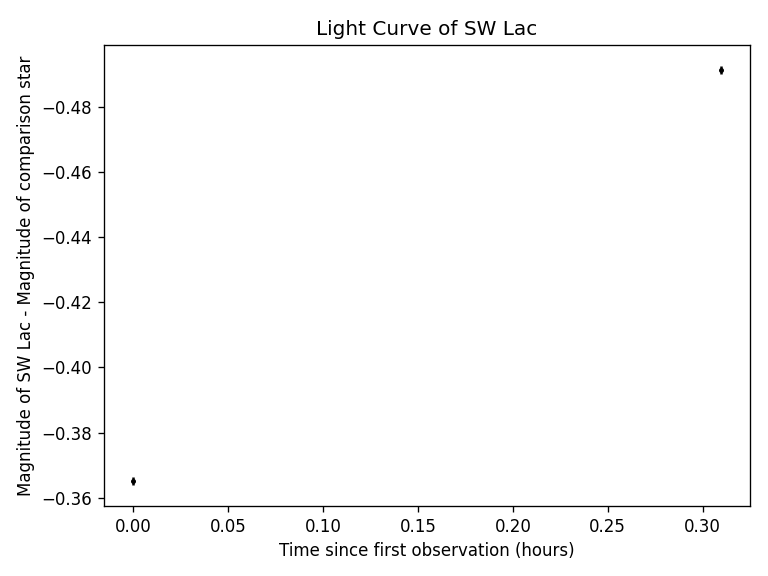

In [14]:
# plotting all the results

plt.figure()
plt.errorbar((sw_lac_results['time'].jd - np.min(sw_lac_results['time'].jd))*24, sw_lac_results['mag'], 
             yerr=sw_lac_results['mag_error'], ls='none', marker='o', markersize=2, color='k')
plt.xlabel('Time since first observation (hours)')
plt.ylabel('Magnitude of SW Lac - Magnitude of comparison star')
plt.title('Light Curve of SW Lac')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.tight_layout()
plt.show()

## Converting to real apparent magnitudes, instead of instrumental magnitudes.

Ok, we now have $m_{SW} - m_{\rm comparison}$ . I.e., the magnitude difference between SW Lac and the comparison star. I chose  BD+37 4715 as my comparison star. It has a roughly constant G magnitude of 8.8282 (found on simbad). All these observations were taken in gp, so we just need to add $m_{\rm comparison} = 8.8282$ to the above magnitude difference.

Note that if you used a set of comparison stars (like group 9 with HD 189733), then you would need to look up the magnitudes of all the comparison stars in the set, convert those magnitudes to "fluxes" (by doing $10^{-0.4 * {\rm magnitude})}$, take the average of the fluxes, then do the average of those fluxes. You would then compute $m_{\rm comparison average} = -2.5\log10 (\rm{average \, of \, fluxes}) $ . Then you can add $m_{\rm comparison average} to your relative light curve above!

<IPython.core.display.Javascript object>


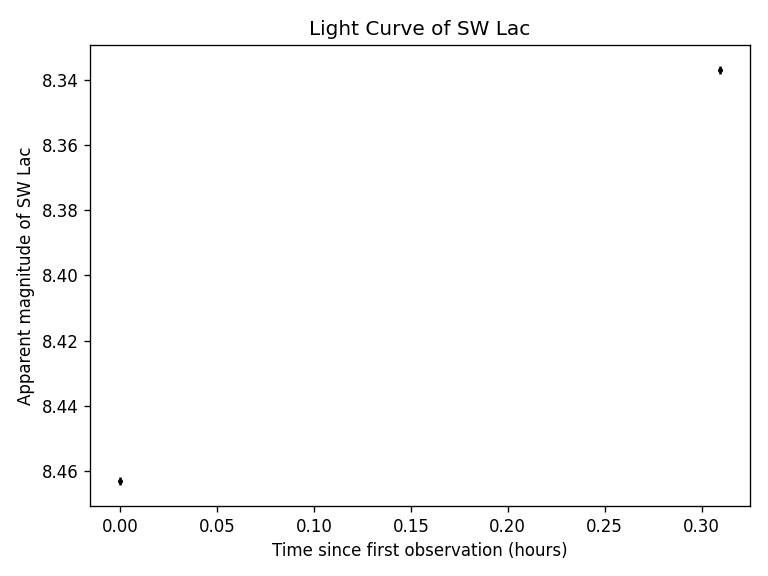

In [15]:
plt.figure()

comparison_magnitude = 8.8282
plt.errorbar(((sw_lac_results['time'].jd - np.min(sw_lac_results['time'].jd)))*24, sw_lac_results['mag'] + comparison_magnitude, 
             yerr=sw_lac_results['mag_error'], ls='none', marker='o', markersize=2, color='k')
plt.xlabel('Time since first observation (hours)')
plt.ylabel('Apparent magnitude of SW Lac')
plt.title('Light Curve of SW Lac')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.tight_layout()
plt.show()

Voila! We now have two sets of magnitudes (and fluxes). 

If this were a standard star, we would want these two mags be roughly equal within the errors. By that I mean that the difference in their two magnitude values is less than mag_err. Ideally, those two datapoints should be within the scatter of one another. This means that we have done things correctly (if this was a standard star).

But SW Lac is a variable star, and the comparison star I chose is not a perfect standard star

And these magnitude differences are many times the formal error. This could be due to variability in SW Lac, or it could be due to the fact that I anchored relative to other stars that could be varying themselves (i.e., it could be due to my "data analysis pipeline" being incorrect!).

Canis Li already found the first bug in here (a data pipeline bug), that is in an earlier version of this notebook.

Hint: Look up a light curve of SW Lac. How much (in magnitude) should it be changing over a period of 0.3 hours?

### Disclaimer: This code is not bullet proof. It may require some tweaking for your star/stars. But it is a starting point!!